In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patch 
import cv2
import numpy as np
import matplotlib.image as mpimg
import math
import sys
import os
from scipy.ndimage.filters import convolve
from scipy.ndimage.filters import gaussian_filter
from scipy import signal as sig
import io
import random
import math
import secrets
from tqdm import tqdm
import scipy.spatial.distance

(450, 450)


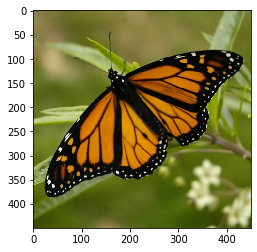

In [53]:
image = cv2.imread('butterfly.jpg')
color_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image = np.array(img)
original_shape = image.shape
print(original_shape)
plt.imshow(color_image,cmap='gray')

In [35]:
row = image.shape[0]
col = image.shape[1]
print(row,col)

450 450


In [36]:
kernelx = [[-1, -2, -1],
           [0, 0, 0],
           [1, 2, 1] ]
kernely = [[-1, 0, 1],
           [-2, 0, 2],
           [-1, 0, 1]]

In [37]:
def sobel_filter(img):
    img2=np.pad(img, (1, 1), 'constant', constant_values=(0, 0))
    
    sobel=np.zeros((img2.shape))
    n=3
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            patch=img2[i:i+n,j:j+n]
            gx=0
            gy=0
            for k in range(patch.shape[0]):
                for l in range(patch.shape[1]):
                    gx += patch[k,l] * kernelx[k][l]
                    gy += patch[k,l] * kernely[k][l]
            val = int(math.sqrt(gx**2 + gy**2))        
            sobel[i,j] = val
    return sobel

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

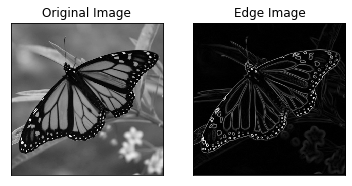

In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('butterfly.jpg',0)
edges = sobel_filter(img)
#edges = cv2.Canny(img,100,90)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

In [42]:
edges.shape

(452, 452)

In [43]:
k=0
mask = np.zeros((row,col))
sp_colors = []
sp_centers=[]
stride = 15
i = 3
for i in tqdm(range(3,row,15)):
    for j in range(3,col,15):
        if (edges[i][j]==0):
            sp_centers.append([i,j])
            sp_colors = [color_image[i,j,:]]
            mask[i,j]=255
        else:
            nb = edges[i-1:i+2,j-1:j+2]
            min_val = np.argmin(nb)
            sp_centers.append([min_val])
            sp_colors.append([color_image[i,j,0],color_image[i,j,1],color_image[i,j,2]])
            mask[i,j]=255
        

100%|██████████| 30/30 [00:00<00:00, 3588.25it/s]


In [44]:
print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0.5, 1.0, 'Centers')

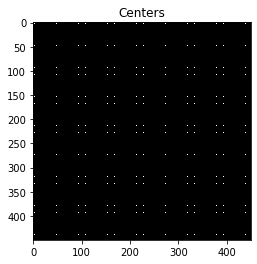

In [45]:
plt.imshow(mask,cmap='gray')
plt.title("Centers")

In [46]:
def euc_dist(a,b):
    dist= np.linalg.norm(a-b)
    dist=abs(dist)
    return dist

In [47]:
image_copy = np.zeros((color_image.shape))

In [48]:
image_copy.shape

(450, 450, 3)

In [49]:
def mean_color(i,j,k,l):
    red = color_image[i,j,0]
    green = color_image[i,j,1]
    blue = color_image[i,j,2]
    
    red1 = color_image[k,l,0]
    green1 = color_image[k,l,1]
    blue1 = color_image[k,l,2]
    
    d_color = np.sqrt(pow((red-red1),2)+pow((green-green1),2)+pow((blue-blue1),2))
    return d_color,red1,green1,blue1   

In [50]:
image_copy = np.zeros((color_image.shape))
M = 10
dic_centers={}
for j in tqdm(range(row)):
    for k in (range(col)):
        centroids = []
        distance=[]
        if (j < stride or k < stride):
            for m in range(2*stride+1):
                for n in range(2*stride+1):
                    if mask[m][n]:
                        centroids.append([m,n])
        if(j>=stride and k>=stride) and (j+stride<row and k+stride<col):
            for m in range(j-stride,stride+j+1):
                for n in range(k-stride,stride+k+1):
                    if mask[m][n]:
                        centroids.append([m,n])      
        else:
            for m in range(row-2*stride,row):
                for n in range(col-2*stride,col):
                    if mask[m][n]:
                        centroids.append([m,n])
    #print(centroids)
        for centers in centroids:
            row1 = centers[0]
            row2 = centers[1]
            dist = euc_dist(j-row1,k-row2)
            distance.append([row1,row2,dist])
        sorted_distance = sorted(distance, key = lambda x: int(x[2]))
        #print(sorted_distance)
        atmost_4_centers = sorted_distance[:4]
        new_list=[]
        #print(len(atmost_4_centers))
        for l in range(0,min(4,len(sorted_distance))):
            x_co,y_co,d_space = sorted_distance[l]
            val = mean_color(j,k,x_co,y_co)
            d_color = val[0]
            formula = d_color + (M/stride)*d_space
            #print(formula)
            new_list.append([formula,val[1],val[2],val[3]])
        sorted_list = sorted(new_list, key = lambda x: int(x[0]),reverse=True)

        d,r,g,b = sorted_list[0]

        image_copy[j][k][0] = r
        image_copy[j][k][1] = g
        image_copy[j][k][2] = b
    #print(j)

  0%|          | 0/450 [00:00<?, ?it/s]/home/surbhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 450/450 [01:47<00:00,  4.20it/s]


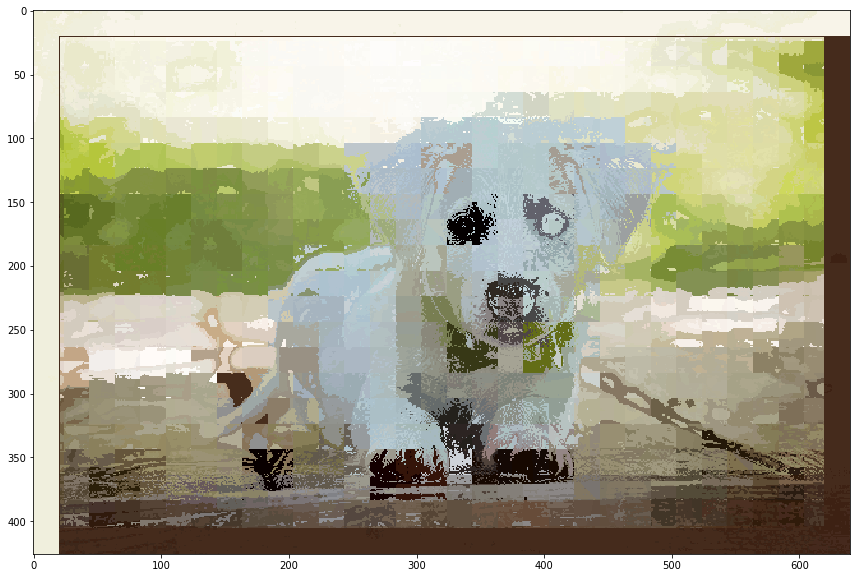

In [112]:
plt.figure(figsize=(15,10))
plt.savefig('SLIC.png',format = "png", dpi = 100)
plt.imshow(image_copy.astype('uint8'))

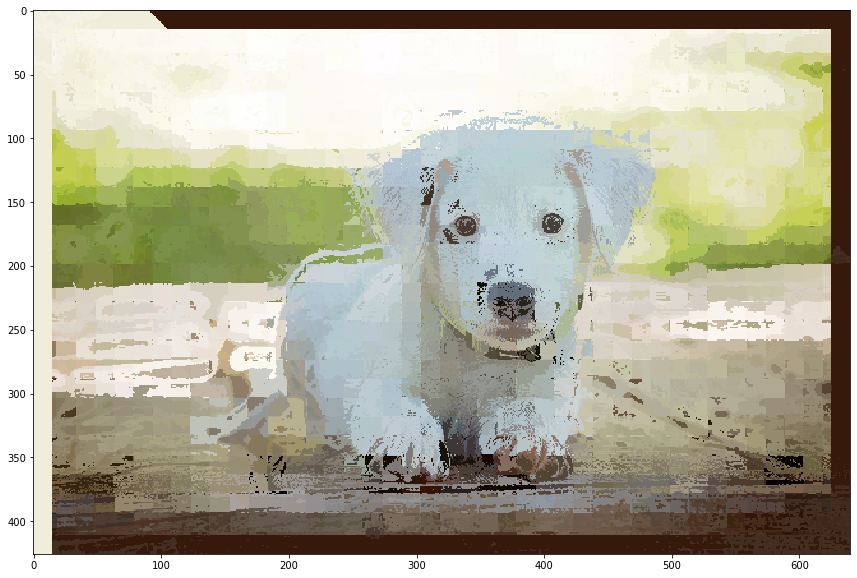

In [33]:
plt.figure(figsize=(15,10))
plt.savefig('SLIC.png',format = "png", dpi = 100)
plt.imshow(image_copy.astype('uint8'))

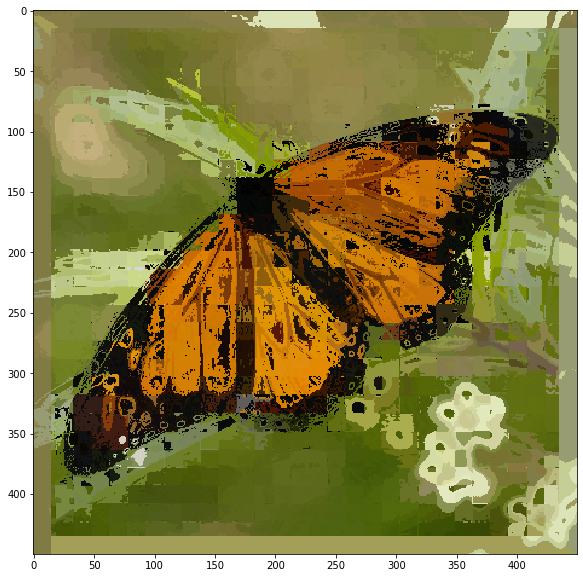

In [51]:
plt.figure(figsize=(15,10))
plt.savefig('SLIC.png',format = "png", dpi = 100)
plt.imshow(image_copy.astype('uint8'))